# Two-Stage Pipeline: Recall → Precision

**Objective:** Build a cascade system to find "interesting" papers:

1. **Stage 1 — Recall engine**: Fast XGBoost on regular features → catch ≥90% of interesting papers
2. **Stage 2 — Precision engine**: LLM citation scoring (gpt-4.1-nano) on recalled papers → second XGBoost to select top X

**Target:** Binary — `interesting` (high citations, age-adjusted) vs `not_interesting`

## Setup

In [36]:
import os
import re
import json
import hashlib
import asyncio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    classification_report, f1_score, accuracy_score,
    precision_recall_curve, precision_score, recall_score,
    confusion_matrix
)
from xgboost import XGBClassifier

from dotenv import load_dotenv
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

SEED = 42
np.random.seed(SEED)
print("Setup complete.")

Setup complete.


---
## Section 1 — Load Data & Binary Target

In [37]:
df = pd.read_csv("../data/eda_papers.csv")
print(f"Loaded {len(df)} papers.")

# Basic features
df["published_at"] = pd.to_datetime(df["published_at"])
df["age_days"] = (pd.Timestamp.now(tz="UTC") - df["published_at"]).dt.days
df["title_len"] = df["title"].apply(len)
df["abstract_len"] = df["abstract"].apply(len)
df["num_authors"] = df["authors"].apply(lambda x: len(str(x).split("|")) if pd.notna(x) else 0)

# Filter very new papers
df = df[df["age_days"] > 30]

# Age binning
df["age_bin"] = (df["age_days"] // 7) * 7
df["age_bin"] = pd.to_numeric(df["age_bin"], errors="coerce")
df["citation_count"] = pd.to_numeric(df["citation_count"], errors="coerce").fillna(0)
df = df.dropna(subset=["age_bin"]).copy()
df["age_bin"] = df["age_bin"].astype(int)

# ── Binary target: interesting vs not_interesting ──
degree = 1.08
c2 = 0.035  # high threshold
high_threshold = c2 * (df["age_bin"] ** degree)
df["interesting"] = (df["citation_count"] >= high_threshold).astype(int)

print(f"\nBinary target distribution:")
print(df["interesting"].value_counts().rename({0: "not_interesting", 1: "interesting"}))
print(f"Interesting rate: {df['interesting'].mean():.2%}")

Loaded 102215 papers.

Binary target distribution:
interesting
not_interesting    98466
interesting         3492
Name: count, dtype: int64
Interesting rate: 3.42%


---
## Section 2 — Feature Engineering

In [38]:
_WORD_RE = re.compile(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?")
_SENT_SPLIT_RE = re.compile(r"[.!?]+\s+")
_URL_RE = re.compile(r"https?://\S+|www\.\S+")
_EMAIL_RE = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")


def add_offline_paper_features(
    df, *, title_col="title", abstract_col="abstract", authors_col="authors",
    primary_cat_col="primary_category", all_cats_col="all_categories",
    published_at_col="published_at", author_sep="|",
):
    """Add offline-only features for impact prediction."""
    out = df.copy()
    def safe_str(s): return "" if pd.isna(s) else str(s)
    def words(s): return _WORD_RE.findall(s)
    def sentence_count(s):
        s = s.strip()
        return 0 if not s else max(1, len(_SENT_SPLIT_RE.split(s)))
    def keyword_flags(text_lower, patterns):
        return {name: int(bool(re.search(pat, text_lower))) for name, pat in patterns.items()}

    # Datetime
    if published_at_col in out.columns:
        dt = pd.to_datetime(out[published_at_col], errors="coerce", utc=True)
        out["pub_hour_utc"] = dt.dt.hour
        out["pub_dow"] = dt.dt.dayofweek
        out["pub_month"] = dt.dt.month
        out["is_weekend"] = dt.dt.dayofweek.isin([5, 6]).astype("Int64")

    # Category features
    if all_cats_col in out.columns:
        cats = out[all_cats_col].fillna("").astype(str)
        out["num_categories"] = cats.apply(lambda x: 0 if x.strip() == "" else len([c for c in x.split("|") if c.strip()]))
        out["is_cross_listed"] = (out["num_categories"] > 1).astype("Int64")
        def starts_with(prefix):
            return cats.apply(lambda x: int(any(c.strip().startswith(prefix) for c in x.split("|") if c.strip())))
        out["has_cs"] = starts_with("cs.")
        out["has_stat"] = starts_with("stat.")
        out["has_math"] = starts_with("math.")
        out["has_eess"] = starts_with("eess.")
        out["has_qbio"] = starts_with("q-bio.")

    if primary_cat_col in out.columns:
        pc = out[primary_cat_col].fillna("").astype(str)
        out["primary_is_cs"] = pc.str.startswith("cs.").astype("Int64")
        out["primary_is_stat"] = pc.str.startswith("stat.").astype("Int64")

    # Author features
    if authors_col in out.columns:
        auth = out[authors_col].fillna("").astype(str)
        author_lists = auth.apply(lambda x: [a.strip() for a in x.split(author_sep) if a.strip()])
        out["num_authors_offline"] = author_lists.apply(len)
        author_name_lens = author_lists.apply(lambda xs: [len(a) for a in xs] if xs else [])
        out["author_name_len_mean"] = author_name_lens.apply(lambda ls: float(np.mean(ls)) if ls else np.nan)
        out["author_name_len_max"] = author_name_lens.apply(lambda ls: float(np.max(ls)) if ls else np.nan)
        out["has_many_authors_ge5"] = (out["num_authors_offline"] >= 5).astype("Int64")
        out["has_many_authors_ge10"] = (out["num_authors_offline"] >= 10).astype("Int64")

    # Text features
    title = out.get(title_col, "").apply(safe_str)
    abstract = out.get(abstract_col, "").apply(safe_str)
    title_lower = title.str.lower()
    abs_lower = abstract.str.lower()
    out["title_char_len"] = title.str.len()
    out["abstract_char_len"] = abstract.str.len()
    out["title_word_count"] = title.apply(lambda s: len(words(s)))
    out["abstract_word_count"] = abstract.apply(lambda s: len(words(s)))
    out["title_avg_word_len"] = title.apply(lambda s: np.mean([len(w) for w in words(s)]) if words(s) else np.nan)
    out["abstract_avg_word_len"] = abstract.apply(lambda s: np.mean([len(w) for w in words(s)]) if words(s) else np.nan)
    out["abstract_sentence_count"] = abstract.apply(sentence_count)
    out["abstract_avg_words_per_sentence"] = out["abstract_word_count"] / out["abstract_sentence_count"].replace(0, np.nan)
    def ratio_of(pattern, s): return len(re.findall(pattern, s)) / max(1, len(s)) if s else 0.0
    out["title_digit_ratio"] = title.apply(lambda s: ratio_of(r"\d", s))
    out["abstract_digit_ratio"] = abstract.apply(lambda s: ratio_of(r"\d", s))
    out["title_punct_ratio"] = title.apply(lambda s: ratio_of(r"[^\w\s]", s))
    out["abstract_punct_ratio"] = abstract.apply(lambda s: ratio_of(r"[^\w\s]", s))
    out["abstract_has_url"] = abstract.apply(lambda s: int(bool(_URL_RE.search(s)))).astype("Int64")
    out["abstract_has_email"] = abstract.apply(lambda s: int(bool(_EMAIL_RE.search(s)))).astype("Int64")
    out["mentions_github"] = abs_lower.str.contains("github.com", regex=False).astype("Int64")
    out["mentions_code"] = abs_lower.str.contains("code", regex=False).astype("Int64")
    out["mentions_dataset"] = abs_lower.str.contains("dataset", regex=False).astype("Int64")
    out["mentions_benchmark"] = abs_lower.str.contains("benchmark", regex=False).astype("Int64")
    out["mentions_arxiv_id"] = abs_lower.str.contains("arxiv", regex=False).astype("Int64")
    out["mentions_doi"] = abs_lower.str.contains("doi", regex=False).astype("Int64")

    kw_patterns = {
        "is_survey": r"\bsurvey\b|\breview\b",
        "is_benchmark_paper": r"\bbenchmark\b|\bleaderboard\b",
        "is_dataset_paper": r"\bdataset\b|\bcorpus\b",
        "is_system_paper": r"\bsystem\b|\bframework\b|\bplatform\b",
        "has_theory": r"\btheorem\b|\bproof\b|\bconvergence\b",
        "mentions_llm": r"\bllm\b|large language model|language model",
        "mentions_diffusion": r"\bdiffusion\b",
        "mentions_transformer": r"\btransformer\b",
        "mentions_agent": r"\bagent\b|\btool\b|\bplanning\b",
        "mentions_rl": r"\breinforcement learning\b|\brl\b",
        "mentions_multimodal": r"\bmultimodal\b|vision-language|vlm",
        "claims_sota": r"\bsota\b|state[- ]of[- ]the[- ]art",
        "claims_novel": r"\bnovel\b|\bnew\b|\bfirst\b|\bintroduce\b",
        "mentions_open_source": r"open[- ]source|we release|code is available",
        "mentions_experiments": r"\bexperiments?\b|\bwe evaluate\b|\bresults?\b",
    }
    combined_lower = (title_lower + " " + abs_lower).fillna("")
    kw_df = pd.DataFrame(combined_lower.apply(lambda s: keyword_flags(s, kw_patterns)).tolist(), index=out.index)
    out = pd.concat([out, kw_df], axis=1)

    def ttr(s):
        ws = [w.lower() for w in words(s)]
        return len(set(ws)) / len(ws) if ws else np.nan
    out["abstract_ttr"] = abstract.apply(ttr)
    out["log_abstract_word_count"] = np.log1p(out["abstract_word_count"])
    out["log_num_authors"] = np.log1p(out.get("num_authors_offline", 0))
    return out

print("Feature engineering function loaded.")

Feature engineering function loaded.


In [39]:
# Apply FE
feat_df = add_offline_paper_features(df)
print(f"feat_df shape: {feat_df.shape}")

# Filter for reliable citation signal
feat_df["age_days"] = pd.to_numeric(feat_df.get("age_days", np.nan), errors="coerce")
model_df = feat_df[feat_df["age_days"] >= 200].copy()
print(f"model_df (age >= 200 days): {model_df.shape}")

# Binary target
y = model_df["interesting"].values
print(f"\nTarget: {sum(y==1)} interesting, {sum(y==0)} not interesting ({sum(y==1)/len(y):.2%})")

# Drop leak/ID columns
TITLE_COL = "title"
ABSTRACT_COL = "abstract"
leak_cols = {"citation_count", "age_days", "age_bin", "popularity_bucket", "interesting"}
id_cols = {"arxiv_id"}
drop_cols = leak_cols | id_cols
X = model_df.drop(columns=[c for c in drop_cols if c in model_df.columns]).copy()

# Store text columns for LLM scoring later
texts_combined = X[TITLE_COL].fillna("") + " " + X[ABSTRACT_COL].fillna("")

# ── Stable train/test split (saved to disk) ──
SPLIT_DIR = "./splits/two_stage"
os.makedirs(SPLIT_DIR, exist_ok=True)
idx_train_path = os.path.join(SPLIT_DIR, "train_idx.npy")
idx_test_path  = os.path.join(SPLIT_DIR, "test_idx.npy")

if os.path.exists(idx_train_path) and os.path.exists(idx_test_path):
    train_idx = np.load(idx_train_path, allow_pickle=True)
    test_idx  = np.load(idx_test_path, allow_pickle=True)
    # Filter to indices that still exist in current data
    train_idx = np.intersect1d(train_idx, X.index)
    test_idx  = np.intersect1d(test_idx, X.index)
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y[X.index.isin(train_idx)], y[X.index.isin(test_idx)]
    print("Loaded existing train/test split from disk.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )
    np.save(idx_train_path, X_train.index.values)
    np.save(idx_test_path, X_test.index.values)
    print("Created and saved new train/test split.")

train_texts = texts_combined.loc[X_train.index].reset_index(drop=True)
test_texts = texts_combined.loc[X_test.index].reset_index(drop=True)

print(f"\nTrain: {X_train.shape[0]} | Test: {X_test.shape[0]}")
print(f"Train interesting rate: {y_train.mean():.2%}")
print(f"Test interesting rate:  {y_test.mean():.2%}")

feat_df shape: (101958, 70)
model_df (age >= 200 days): (52079, 70)

Target: 2276 interesting, 49803 not interesting (4.37%)
Created and saved new train/test split.

Train: 41663 | Test: 10416
Train interesting rate: 4.37%
Test interesting rate:  4.37%


In [40]:
# ── Numerical imputation + OHE ──
cat_cols = ["primary_category"] if "primary_category" in X_train.columns else []
num_cols = X_train.select_dtypes(include=["int64", "int32", "float64", "float32", "bool"]).columns.tolist()
num_cols = [c for c in num_cols if c not in {TITLE_COL, ABSTRACT_COL}]

num_imputer = SimpleImputer(strategy="median")
X_train_num = num_imputer.fit_transform(X_train[num_cols]).astype(np.float32)
X_test_num  = num_imputer.transform(X_test[num_cols]).astype(np.float32)

if cat_cols:
    cat_imputer = SimpleImputer(strategy="most_frequent")
    X_train_cat_raw = cat_imputer.fit_transform(X_train[cat_cols])
    X_test_cat_raw  = cat_imputer.transform(X_test[cat_cols])
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train_cat_raw).astype(np.float32)
    X_test_cat  = ohe.transform(X_test_cat_raw).astype(np.float32)
    ohe_col_names = list(ohe.get_feature_names_out(cat_cols))
else:
    X_train_cat = np.zeros((len(X_train), 0), np.float32)
    X_test_cat  = np.zeros((len(X_test), 0), np.float32)
    ohe_col_names = []

# Final feature matrices
X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final  = np.hstack([X_test_num, X_test_cat])
col_names = num_cols + ohe_col_names

print(f"Features: {len(num_cols)} numerical + {len(ohe_col_names)} OHE = {X_train_final.shape[1]} total")

Features: 59 numerical + 124 OHE = 183 total


### Feature Deduplication

Remove redundant/correlated features to reduce noise:

| Group | Dropped | Kept |
|---|---|---|
| Author count (5→1) | `num_authors`, `num_authors_offline`, `has_many_authors_ge5/ge10` | `log_num_authors` |
| Title length (3→1) | `title_len`, `title_char_len` | `title_word_count` |
| Abstract length (4→1) | `abstract_len`, `abstract_char_len`, `abstract_word_count` | `log_abstract_word_count` |
| Code signals (3→1) | `mentions_code`, `mentions_open_source` | `mentions_github` |

In [41]:
# ── Drop redundant features (same groups as further_fe_clean Section 5) ──
DROP_FEATURES = {
    # Author count (5 → keep log_num_authors)
    "num_authors", "num_authors_offline",
    "has_many_authors_ge5", "has_many_authors_ge10",
    # Title length (3 → keep title_word_count)
    "title_len", "title_char_len",
    # Abstract length (4 → keep log_abstract_word_count)
    "abstract_len", "abstract_char_len", "abstract_word_count",
    # Code signals (3 → keep mentions_github)
    "mentions_code", "mentions_open_source",
}

keep_idx = [i for i, c in enumerate(col_names) if c not in DROP_FEATURES]
col_names_clean = [col_names[i] for i in keep_idx]

X_train_final = X_train_final[:, keep_idx]
X_test_final  = X_test_final[:, keep_idx]
col_names = col_names_clean  # update for downstream use

print(f"Dropped {len(DROP_FEATURES)} redundant features")
print(f"Final feature count: {X_train_final.shape[1]}")

Dropped 11 redundant features
Final feature count: 172


---
## Section 3 — Stage 1: Recall Engine

Train XGBoost on the **full training set** with binary target.
Then sweep probability thresholds to find the operating point that achieves
≥90% or ≥95% recall for the "interesting" class.

In [42]:
# ── Train recall-optimized XGBoost ──
from sklearn.utils.class_weight import compute_sample_weight

sw = compute_sample_weight("balanced", y_train)

recall_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=1,
    reg_lambda=2.0,
    scale_pos_weight=1,  # using sample weights instead
    random_state=SEED,
    n_jobs=-1,
)
recall_clf.fit(X_train_final, y_train, sample_weight=sw)

# Get probabilities
y_prob_train = recall_clf.predict_proba(X_train_final)[:, 1]
y_prob_test  = recall_clf.predict_proba(X_test_final)[:, 1]

print(f"Default threshold (0.5):")
y_pred_default = (y_prob_test >= 0.5).astype(int)
print(classification_report(y_test, y_pred_default, target_names=["not_interesting", "interesting"]))

Default threshold (0.5):
                 precision    recall  f1-score   support

not_interesting       0.98      0.92      0.95      9961
    interesting       0.23      0.52      0.32       455

       accuracy                           0.90     10416
      macro avg       0.60      0.72      0.63     10416
   weighted avg       0.94      0.90      0.92     10416



In [43]:
# ── Threshold sweep for recall targets ──
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_test)

# Find thresholds for 90% and 95% recall
recall_targets = [0.90, 0.95]
results = {}

for target in recall_targets:
    # recalls is sorted descending, find highest threshold that achieves target recall
    valid = np.where(recalls[:-1] >= target)[0]
    if len(valid) == 0:
        print(f"Cannot achieve {target:.0%} recall")
        continue
    best_idx = valid[-1]  # highest threshold that still achieves target
    t = thresholds[best_idx]
    
    y_pred_t = (y_prob_test >= t).astype(int)
    r = recall_score(y_test, y_pred_t)
    p = precision_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    n_recalled = y_pred_t.sum()
    n_true_pos = ((y_pred_t == 1) & (y_test == 1)).sum()
    n_false_pos = ((y_pred_t == 1) & (y_test == 0)).sum()
    
    results[target] = {
        "threshold": t, "recall": r, "precision": p, "f1": f1,
        "recalled": n_recalled, "true_pos": n_true_pos, "false_pos": n_false_pos
    }
    print(f"\n{'='*60}")
    print(f"Recall target: {target:.0%} | Threshold: {t:.4f}")
    print(f"{'='*60}")
    print(f"  Recall:     {r:.2%} ({n_true_pos}/{sum(y_test==1)} interesting found)")
    print(f"  Precision:  {p:.2%} ({n_true_pos}/{n_recalled} recalled are interesting)")
    print(f"  F1:         {f1:.4f}")
    print(f"  Recalled:   {n_recalled} papers ({n_recalled/len(y_test):.1%} of test set)")
    print(f"  False pos:  {n_false_pos} papers")


Recall target: 90% | Threshold: 0.0839
  Recall:     90.11% (410/455 interesting found)
  Precision:  8.15% (410/5028 recalled are interesting)
  F1:         0.1496
  Recalled:   5028 papers (48.3% of test set)
  False pos:  4618 papers

Recall target: 95% | Threshold: 0.0443
  Recall:     95.16% (433/455 interesting found)
  Precision:  6.61% (433/6548 recalled are interesting)
  F1:         0.1237
  Recalled:   6548 papers (62.9% of test set)
  False pos:  6115 papers


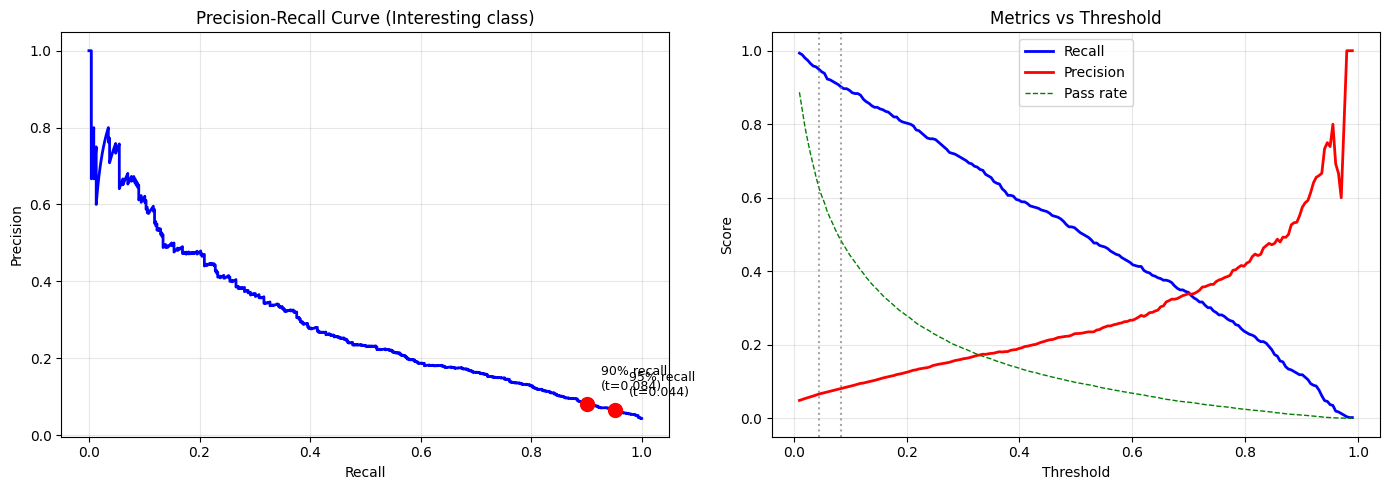

In [44]:
# ── Precision-Recall curve ──
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# PR curve
ax1.plot(recalls, precisions, 'b-', linewidth=2)
for target, res in results.items():
    ax1.plot(res['recall'], res['precision'], 'ro', markersize=10)
    ax1.annotate(f"{target:.0%} recall\n(t={res['threshold']:.3f})",
                 (res['recall'], res['precision']),
                 textcoords='offset points', xytext=(10, 10), fontsize=9)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve (Interesting class)')
ax1.grid(True, alpha=0.3)

# Threshold vs metrics
thresh_range = np.linspace(0.01, 0.99, 200)
recalls_sweep = [recall_score(y_test, (y_prob_test >= t).astype(int)) for t in thresh_range]
precisions_sweep = [precision_score(y_test, (y_prob_test >= t).astype(int), zero_division=0) for t in thresh_range]
pass_rate = [(y_prob_test >= t).mean() for t in thresh_range]

ax2.plot(thresh_range, recalls_sweep, 'b-', label='Recall', linewidth=2)
ax2.plot(thresh_range, precisions_sweep, 'r-', label='Precision', linewidth=2)
ax2.plot(thresh_range, pass_rate, 'g--', label='Pass rate', linewidth=1)
for target, res in results.items():
    ax2.axvline(res['threshold'], color='gray', linestyle=':', alpha=0.7)
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Score')
ax2.set_title('Metrics vs Threshold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [45]:
# ── Select operating point & apply recall filter ──
# Use 90% recall as default (user can change)
RECALL_TARGET = 0.90
RECALL_THRESHOLD = results[RECALL_TARGET]["threshold"]

# Apply to train and test
recalled_train_mask = y_prob_train >= RECALL_THRESHOLD
recalled_test_mask  = y_prob_test >= RECALL_THRESHOLD

print(f"Operating point: {RECALL_TARGET:.0%} recall @ threshold={RECALL_THRESHOLD:.4f}")
print(f"\nTrain: {recalled_train_mask.sum():,} / {len(y_train):,} recalled ({recalled_train_mask.mean():.1%})")
print(f"Test:  {recalled_test_mask.sum():,} / {len(y_test):,} recalled ({recalled_test_mask.mean():.1%})")

# Prepare recalled subsets
X_train_recalled = X_train_final[recalled_train_mask]
X_test_recalled  = X_test_final[recalled_test_mask]
y_train_recalled = y_train[recalled_train_mask]
y_test_recalled  = y_test[recalled_test_mask]

train_texts_recalled = train_texts[recalled_train_mask].reset_index(drop=True)
test_texts_recalled  = test_texts[recalled_test_mask].reset_index(drop=True)

print(f"\nRecalled train interesting rate: {y_train_recalled.mean():.2%} (vs {y_train.mean():.2%} overall)")
print(f"Recalled test interesting rate:  {y_test_recalled.mean():.2%} (vs {y_test.mean():.2%} overall)")

Operating point: 90% recall @ threshold=0.0839

Train: 19,517 / 41,663 recalled (46.8%)
Test:  5,028 / 10,416 recalled (48.3%)

Recalled train interesting rate: 9.33% (vs 4.37% overall)
Recalled test interesting rate:  8.15% (vs 4.37% overall)


---
## Section 4 — Stage 2: LLM Citation Scoring

Score **only recalled papers** with gpt-4.1-nano using a citation-focused prompt.
This drastically reduces API cost compared to scoring all papers.

In [ ]:
# ── Citation-focused LLM utilities ──
import httpx
from openai import AsyncOpenAI, RateLimitError, APIConnectionError, APITimeoutError
from tqdm.notebook import tqdm
import nest_asyncio

LLM_MODEL = "gpt-4.1-nano"
LLM_MAX_CHARS = 2000
LLM_CACHE_DIR = "./llm_score_cache"
CONCURRENCY = 12
os.makedirs(LLM_CACHE_DIR, exist_ok=True)

CITE_SCORE_KEYS = [
    "citation_potential", "methodological_novelty", "practical_utility",
    "topic_trendiness", "reusability", "community_breadth", "writing_accessibility",
]
CITE_FLAG_KEYS = [
    "introduces_framework", "new_dataset_or_benchmark", "comprehensive_survey",
    "addresses_open_problem", "strong_empirical_results", "cross_disciplinary",
    "provides_theoretical_insight",
]
CITE_TIER_VALUES = ["very_high", "high", "medium", "low"]


def _stable_hash(s):
    return hashlib.sha256(s.encode("utf-8")).hexdigest()

def shorten_text(text, max_chars=2000):
    return text[:max_chars] if len(text) > max_chars else text

def load_jsonl_cache(path):
    cache = {}
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                rec = json.loads(line)
                cache[rec["key"]] = rec["value"]
    return cache

def append_jsonl(path, record):
    with open(path, "a", encoding="utf-8") as f:
        f.write(json.dumps(record, ensure_ascii=False) + "\n")


_JSON_FENCE_RE = re.compile(r"```(?:json)?\s*(\{.*?\})\s*```", re.DOTALL)
_JSON_OBJ_RE  = re.compile(r"(\{.*\})", re.DOTALL)

def parse_json_strictish(s):
    s = (s or "").strip()
    try: return json.loads(s)
    except: pass
    m = _JSON_FENCE_RE.search(s)
    if m: return json.loads(m.group(1))
    m = _JSON_OBJ_RE.search(s)
    if m: return json.loads(m.group(1))
    raise json.JSONDecodeError("No valid JSON", s, 0)


def make_cite_prompt(text):
    return f"""Return STRICT JSON ONLY (no markdown, no backticks, no explanation).

You are an expert AI researcher. Given a paper's title and abstract,
predict its CITATION IMPACT — how likely it is to be widely cited.

Think about: Does it introduce something others will build on?
Is the topic trending? Would many communities reference this?

Schema (exact keys, no extras):
{{
  "scores": {{
    "citation_potential": 0-10,
    "methodological_novelty": 0-10,
    "practical_utility": 0-10,
    "topic_trendiness": 0-10,
    "reusability": 0-10,
    "community_breadth": 0-10,
    "writing_accessibility": 0-10
  }},
  "flags": {{
    "introduces_framework": 0|1,
    "new_dataset_or_benchmark": 0|1,
    "comprehensive_survey": 0|1,
    "addresses_open_problem": 0|1,
    "strong_empirical_results": 0|1,
    "cross_disciplinary": 0|1,
    "provides_theoretical_insight": 0|1
  }},
  "citation_tier": "very_high|high|medium|low"
}}

Scoring guide: 0-2 very low, 3-4 below avg, 5-6 average, 7-8 strong, 9-10 exceptional.

Text:
{text}"""


def normalize_cite(data):
    out = {}
    scores = data.get("scores", {})
    for k in CITE_SCORE_KEYS:
        out[k] = max(0, min(10, int(scores.get(k, 0))))
    flags = data.get("flags", {})
    for k in CITE_FLAG_KEYS:
        out[k] = 1 if int(flags.get(k, 0)) else 0
    tier = str(data.get("citation_tier", "low")).strip().lower()
    out["citation_tier"] = tier if tier in CITE_TIER_VALUES else "low"
    return out


async def score_one_cite(client, key, text, sem, max_attempts=6):
    for attempt in range(1, max_attempts + 1):
        try:
            async with sem:
                resp = await client.responses.create(model=LLM_MODEL, input=make_cite_prompt(text))
            raw = getattr(resp, "output_text", None) or str(resp)
            return normalize_cite(parse_json_strictish(raw))
        except (RateLimitError,):
            await asyncio.sleep(min(60, (2 ** attempt) + np.random.rand()))
        except (APIConnectionError, APITimeoutError, httpx.ReadTimeout, httpx.ConnectTimeout):
            await asyncio.sleep(min(60, (2 ** attempt) + np.random.rand()))
        except Exception:
            await asyncio.sleep(min(30, (1.5 ** attempt) + np.random.rand()))
    out = {k: 0 for k in CITE_SCORE_KEYS + CITE_FLAG_KEYS}
    out["citation_tier"] = "low"
    return out


async def score_texts_cite_async(texts, cache_path):
    cache = load_jsonl_cache(cache_path)
    pending, results = [], {}
    for idx, raw in texts.items():
        short = shorten_text(raw, max_chars=LLM_MAX_CHARS)
        key = _stable_hash(short)
        if key in cache:
            results[idx] = cache[key]
        else:
            pending.append((idx, key, short))
    print(f"Cache hits: {len(results)} / {len(texts)} | To score: {len(pending)}")
    if pending:
        client = AsyncOpenAI(api_key=OPENAI_API_KEY)
        sem = asyncio.Semaphore(CONCURRENCY)
        # Use as_completed + tqdm.notebook for visible progress in Jupyter
        async def _score_with_idx(i, idx, key, text):
            val = await score_one_cite(client, key, text, sem)
            return i, idx, key, val
        coros = [_score_with_idx(i, idx, k, t) for i, (idx, k, t) in enumerate(pending)]
        pbar = tqdm(total=len(coros), desc=f"Scoring ({LLM_MODEL})")
        for fut in asyncio.as_completed(coros):
            i, idx, key, val = await fut
            results[idx] = val
            append_jsonl(cache_path, {"key": key, "value": val})
            pbar.update(1)
        pbar.close()
    print(f"Done — scored {len(texts)}/{len(texts)}")
    return pd.DataFrame.from_dict(results, orient="index").sort_index()


def score_texts_cite(texts, cache_path):
    coro = score_texts_cite_async(texts, cache_path)
    try:
        loop = asyncio.get_running_loop()
    except RuntimeError:
        loop = None
    if loop and loop.is_running():
        nest_asyncio.apply()
        return loop.run_until_complete(coro)
    else:
        return asyncio.run(coro)


print(f"LLM scoring utilities loaded. Model: {LLM_MODEL}")

In [ ]:
# ── Score recalled papers only ──
CACHE_TRAIN = os.path.join(LLM_CACHE_DIR, "pipeline_train_gpt41nano.jsonl")
CACHE_TEST  = os.path.join(LLM_CACHE_DIR, "pipeline_test_gpt41nano.jsonl")

print(f"Scoring {len(train_texts_recalled)} recalled TRAIN papers...")
llm_train = score_texts_cite(train_texts_recalled, CACHE_TRAIN)

print(f"\nScoring {len(test_texts_recalled)} recalled TEST papers...")
llm_test = score_texts_cite(test_texts_recalled, CACHE_TEST)

Scoring 19517 recalled TRAIN papers...
Cache hits: 13290 / 19517 | To score: 6227


In [ ]:
# ── Sanity check ──
print("LLM score distributions (train):")
display(llm_train[CITE_SCORE_KEYS].describe().T[["mean", "std", "min", "max"]])

print("\nCitation tier distribution:")
print(llm_train["citation_tier"].value_counts())

# Check for zeros
zero_mask = llm_train[CITE_SCORE_KEYS].sum(axis=1) == 0
print(f"\nAll-zero entries: {zero_mask.sum()} / {len(llm_train)}")

---
## Section 5 — Stage 2: Precision XGBoost

Train a second XGBoost **only on recalled papers** using LLM features.
This model ranks papers by P(interesting) within the recalled set.

In [62]:
# ── Prepare LLM features for precision model ──
llm_num_cols = CITE_SCORE_KEYS + CITE_FLAG_KEYS
X_train_llm = llm_train[llm_num_cols].to_numpy(dtype=np.float32)
X_test_llm  = llm_test[llm_num_cols].to_numpy(dtype=np.float32)

# OHE for citation_tier
ohe_tier = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_tier = ohe_tier.fit_transform(llm_train[["citation_tier"]]).astype(np.float32)
X_test_tier  = ohe_tier.transform(llm_test[["citation_tier"]]).astype(np.float32)
tier_names = list(ohe_tier.get_feature_names_out(["citation_tier"]))

# Combine: recalled original features + LLM features
X_train_s2 = np.hstack([X_train_recalled, X_train_llm, X_train_tier])
X_test_s2  = np.hstack([X_test_recalled,  X_test_llm,  X_test_tier])
s2_col_names = col_names + llm_num_cols + tier_names

print(f"Stage 2 features: {X_train_recalled.shape[1]} original + {X_train_llm.shape[1] + X_train_tier.shape[1]} LLM = {X_train_s2.shape[1]} total")
print(f"Stage 2 train: {X_train_s2.shape[0]} | test: {X_test_s2.shape[0]}")

Stage 2 features: 172 original + 18 LLM = 190 total
Stage 2 train: 19517 | test: 5028


In [63]:
# ── Train precision XGBoost ──
sw_s2 = compute_sample_weight("balanced", y_train_recalled)

precision_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=1,
    reg_lambda=2.0,
    random_state=SEED,
    n_jobs=-1,
)
precision_clf.fit(X_train_s2, y_train_recalled, sample_weight=sw_s2)

# Get probabilities on recalled test set
y_prob_s2 = precision_clf.predict_proba(X_test_s2)[:, 1]

print("Stage 2 XGBoost trained on recalled papers.")
print(f"\nDefault (0.5) performance on recalled test set:")
y_pred_s2 = (y_prob_s2 >= 0.5).astype(int)
print(classification_report(y_test_recalled, y_pred_s2, target_names=["not_interesting", "interesting"]))

Stage 2 XGBoost trained on recalled papers.

Default (0.5) performance on recalled test set:
                 precision    recall  f1-score   support

not_interesting       0.95      0.86      0.91      4618
    interesting       0.25      0.52      0.34       410

       accuracy                           0.84      5028
      macro avg       0.60      0.69      0.62      5028
   weighted avg       0.90      0.84      0.86      5028



In [64]:
# ── Top-X selection: precision at different cutoffs ──
# Rank recalled test papers by Stage 2 probability
ranking = np.argsort(-y_prob_s2)  # descending

print("Precision@K — how many of top K papers are truly interesting?")
print(f"{'K':>6} {'Precision':>10} {'True pos':>10} {'Total interesting':>18}")
print("-" * 50)

total_interesting = y_test_recalled.sum()
top_k_results = []

for k in [5, 10, 20, 30, 50, 100, 200]:
    if k > len(ranking):
        break
    top_k_labels = y_test_recalled[ranking[:k]]
    tp = top_k_labels.sum()
    prec = tp / k
    top_k_results.append({"K": k, "Precision": prec, "True_pos": tp})
    print(f"{k:>6} {prec:>10.2%} {tp:>10} {total_interesting:>18}")

# Compare to random baseline
random_precision = y_test_recalled.mean()
print(f"\nRandom baseline precision: {random_precision:.2%}")
print(f"(i.e., {random_precision:.2%} of recalled papers are interesting)")

Precision@K — how many of top K papers are truly interesting?
     K  Precision   True pos  Total interesting
--------------------------------------------------
     5    100.00%          5                410
    10     80.00%          8                410
    20     65.00%         13                410
    30     60.00%         18                410
    50     58.00%         29                410
   100     58.00%         58                410
   200     47.50%         95                410

Random baseline precision: 8.15%
(i.e., 8.15% of recalled papers are interesting)


---
## Section 6 — End-to-End Evaluation

Evaluate the full cascade:
**All papers → Stage 1 (recall) → Stage 2 (precision) → Top X**

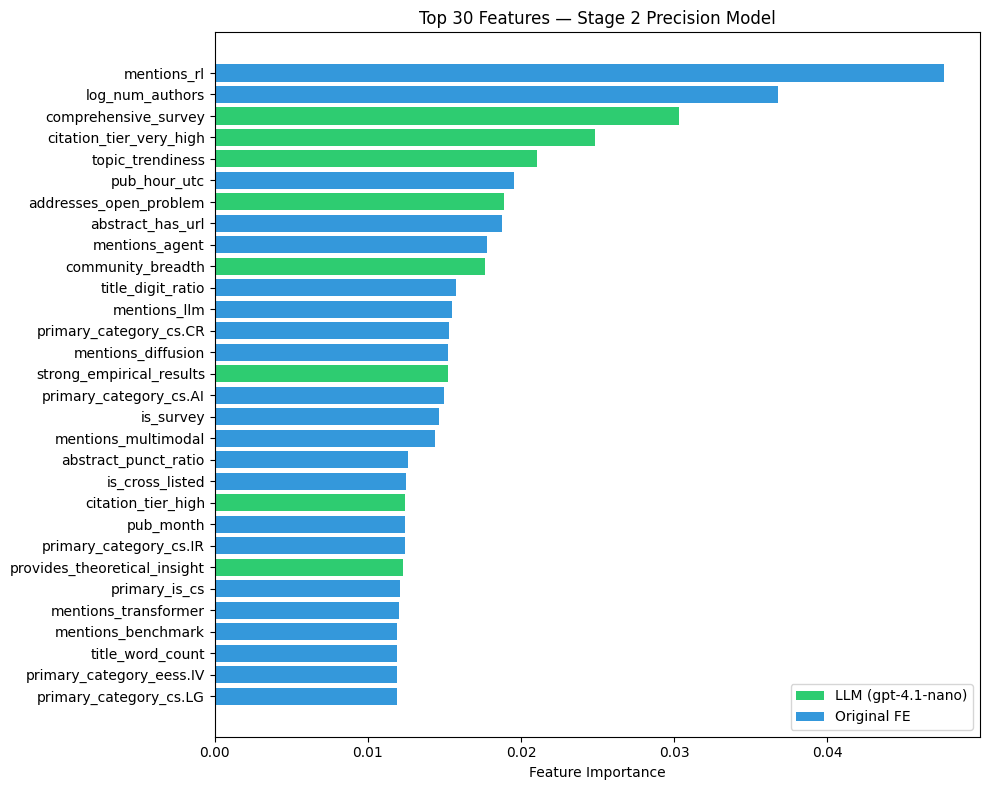


LLM features in top 30: 8


,feature,importance,source
181,comprehensive_survey,0.030348,🟢 LLM
189,citation_tier_very_high,0.024852,🟢 LLM
175,topic_trendiness,0.021017,🟢 LLM
182,addresses_open_problem,0.018899,🟢 LLM
177,community_breadth,0.017626,🟢 LLM
183,strong_empirical_results,0.015243,🟢 LLM
186,citation_tier_high,0.012451,🟢 LLM
185,provides_theoretical_insight,0.012280,🟢 LLM


In [65]:
# ── Feature importance for Stage 2 model ──
imp_s2 = pd.DataFrame({"feature": s2_col_names, "importance": precision_clf.feature_importances_})
imp_s2 = imp_s2.sort_values("importance", ascending=False)

llm_feat_set = set(llm_num_cols + tier_names)
imp_s2["source"] = imp_s2["feature"].apply(
    lambda f: "🟢 LLM" if f in llm_feat_set else "⬜ Original"
)

fig, ax = plt.subplots(figsize=(10, 8))
top30 = imp_s2.head(30)
colors = ["#2ecc71" if s == "🟢 LLM" else "#3498db" for s in top30["source"][::-1]]
ax.barh(top30["feature"][::-1], top30["importance"][::-1], color=colors)
ax.set_xlabel("Feature Importance")
ax.set_title("Top 30 Features — Stage 2 Precision Model")
from matplotlib.patches import Patch
ax.legend(handles=[
    Patch(facecolor="#2ecc71", label="LLM (gpt-4.1-nano)"),
    Patch(facecolor="#3498db", label="Original FE"),
], loc="lower right")
plt.tight_layout()
plt.show()

print(f"\nLLM features in top 30: {(top30['source'] == '🟢 LLM').sum()}")
display(top30[top30['source'] == '🟢 LLM'])

In [66]:
# ── End-to-end cascade summary (precision-focused) ──
total_test = len(y_test)
total_interesting_all = y_test.sum()

# Stage 1 performance
s1_recalled = recalled_test_mask.sum()
s1_tp = ((recalled_test_mask) & (y_test == 1)).sum()
s1_recall = s1_tp / total_interesting_all
s1_precision = s1_tp / s1_recalled

# Best cascade for a few K values
print("=" * 75)
print("END-TO-END CASCADE PERFORMANCE (Precision-Focused)")
print("=" * 75)
print(f"\nTotal test papers: {total_test:,}")
print(f"Total interesting: {total_interesting_all} ({total_interesting_all/total_test:.2%})")
print(f"\nStage 1 (Recall engine @ {RECALL_TARGET:.0%} target):")
print(f"  Recalled: {s1_recalled} papers ({s1_recalled/total_test:.1%} of all)")
print(f"  Recall:   {s1_recall:.2%} ({s1_tp}/{total_interesting_all} interesting found)")
print(f"  Precision: {s1_precision:.2%}")

random_precision = total_interesting_all / total_test

print(f"\nStage 2 (Precision engine — top K from recalled):")
cascade_rows = []
for k in [5, 10, 20, 50, 100]:
    if k > len(ranking):
        break
    tp = y_test_recalled[ranking[:k]].sum()
    prec = tp / k
    lift = prec / random_precision
    cascade_rows.append({
        "Top K": k,
        "Precision": f"{prec:.1%}",
        "Interesting found": f"{tp}",
        "Precision lift vs random": f"{lift:.1f}x",
        "Funnel": f"{total_test}→{s1_recalled}→{k}"
    })

display(pd.DataFrame(cascade_rows))

print(f"\n── Summary ──")
print(f"Baseline (random): {random_precision:.2%} precision")
print(f"Stage 1 alone:     {s1_precision:.2%} precision ({s1_precision/random_precision:.1f}x vs random)")
if cascade_rows:
    best_row = cascade_rows[0]
    print(f"Cascade top-{best_row['Top K']}:     {best_row['Precision']} precision ({best_row['Precision lift vs random']} vs random)")


END-TO-END CASCADE PERFORMANCE (Precision-Focused)

Total test papers: 10,416
Total interesting: 455 (4.37%)

Stage 1 (Recall engine @ 90% target):
  Recalled: 5028 papers (48.3% of all)
  Recall:   90.11% (410/455 interesting found)
  Precision: 8.15%

Stage 2 (Precision engine — top K from recalled):


,Top K,Precision,Interesting found,Precision lift vs random,Funnel
0,5,100.0%,5,22.9x,10416→5028→5
1,10,80.0%,8,18.3x,10416→5028→10
2,20,65.0%,13,14.9x,10416→5028→20
3,50,58.0%,29,13.3x,10416→5028→50
4,100,58.0%,58,13.3x,10416→5028→100



── Summary ──
Baseline (random): 4.37% precision
Stage 1 alone:     8.15% precision (1.9x vs random)
Cascade top-5:     100.0% precision (22.9x vs random)


In [67]:
# ── Per-month breakdown: top-X within each month ──
# Get publication month for test papers using the original model_df
test_original_idx = X_test.index  # original indices into model_df
test_pub_month = model_df.loc[test_original_idx, "published_at"].dt.to_period("M")

# For recalled test papers, get their month
recalled_test_idx = X_test.index[recalled_test_mask]
recalled_pub_month = model_df.loc[recalled_test_idx, "published_at"].dt.to_period("M")

# Build a DataFrame with recalled test papers, their month, probabilities, and labels
recalled_df = pd.DataFrame({
    "prob_s2": y_prob_s2,
    "y_true": y_test_recalled,
    "month": recalled_pub_month.values,
}, index=range(len(y_prob_s2)))

# Also build a full test DataFrame for computing per-month totals
full_test_df = pd.DataFrame({
    "y_true": y_test,
    "month": test_pub_month.values,
}, index=range(len(y_test)))

TOP_K_VALUES = [5, 10, 20]

print("=" * 75)
print("PER-MONTH PRECISION ANALYSIS")
print("=" * 75)
print(f"\nFor each month, take top-K from that month's recalled papers,")
print(f"then report precision (how many of top-K are interesting)")
print(f"and recall (how many of that month's interesting papers are in top-K).\n")

for top_k in TOP_K_VALUES:
    print(f"\n{'─' * 60}")
    print(f"  Top K = {top_k} per month")
    print(f"{'─' * 60}")
    
    month_rows = []
    months_sorted = sorted(recalled_df["month"].unique())
    
    for month in months_sorted:
        # Papers recalled for this month
        month_mask = recalled_df["month"] == month
        month_recalled = recalled_df[month_mask].copy()
        
        # Total interesting in this month (across ALL test papers, not just recalled)
        full_month_mask = full_test_df["month"] == month
        total_in_month = full_test_df[full_month_mask]["y_true"].sum()
        total_papers_in_month = full_month_mask.sum()
        
        n_recalled_month = len(month_recalled)
        
        if n_recalled_month == 0:
            continue
        
        k = min(top_k, n_recalled_month)
        
        # Rank by Stage 2 probability  
        month_ranking = month_recalled["prob_s2"].values.argsort()[::-1]
        top_labels = month_recalled["y_true"].values[month_ranking[:k]]
        tp = top_labels.sum()
        prec = tp / k if k > 0 else 0
        recall_month = tp / total_in_month if total_in_month > 0 else 0
        
        month_rows.append({
            "Month": str(month),
            "Papers": total_papers_in_month,
            "Interesting": int(total_in_month),
            "Recalled": n_recalled_month,
            f"Top-{top_k} precision": f"{prec:.1%}",
            f"Top-{top_k} recall": f"{recall_month:.1%}",
            f"Interesting found": int(tp),
        })
    
    display(pd.DataFrame(month_rows))

print(f"\n{'=' * 75}")
print("Note: 'recall' here = fraction of that month's interesting papers found in the month's top-K.")
print("Low recall is expected when K is small relative to the number of interesting papers.")


PER-MONTH PRECISION ANALYSIS

For each month, take top-K from that month's recalled papers,
then report precision (how many of top-K are interesting)
and recall (how many of that month's interesting papers are in top-K).


────────────────────────────────────────────────────────────
  Top K = 5 per month
────────────────────────────────────────────────────────────


/var/folders/6j/hw4k0h1n0kj4wl569wh828l40000gn/T/ipykernel_50478/3422108922.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  test_pub_month = model_df.loc[test_original_idx, "published_at"].dt.to_period("M")
/var/folders/6j/hw4k0h1n0kj4wl569wh828l40000gn/T/ipykernel_50478/3422108922.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  recalled_pub_month = model_df.loc[recalled_test_idx, "published_at"].dt.to_period("M")


,Month,Papers,Interesting,Recalled,Top-5 precision,Top-5 recall,Interesting found
0,2025-02,1306,95,763,40.0%,2.1%,2
1,2025-03,1808,96,1099,60.0%,3.1%,3
2,2025-04,1422,62,775,100.0%,8.1%,5
3,2025-05,2301,91,1041,40.0%,2.2%,2
4,2025-06,1889,74,780,60.0%,4.1%,3
5,2025-07,1614,35,549,60.0%,8.6%,3
6,2025-08,76,2,21,0.0%,0.0%,0



────────────────────────────────────────────────────────────
  Top K = 10 per month
────────────────────────────────────────────────────────────


,Month,Papers,Interesting,Recalled,Top-10 precision,Top-10 recall,Interesting found
0,2025-02,1306,95,763,50.0%,5.3%,5
1,2025-03,1808,96,1099,60.0%,6.2%,6
2,2025-04,1422,62,775,80.0%,12.9%,8
3,2025-05,2301,91,1041,50.0%,5.5%,5
4,2025-06,1889,74,780,50.0%,6.8%,5
5,2025-07,1614,35,549,40.0%,11.4%,4
6,2025-08,76,2,21,0.0%,0.0%,0



────────────────────────────────────────────────────────────
  Top K = 20 per month
────────────────────────────────────────────────────────────


,Month,Papers,Interesting,Recalled,Top-20 precision,Top-20 recall,Interesting found
0,2025-02,1306,95,763,50.0%,10.5%,10
1,2025-03,1808,96,1099,75.0%,15.6%,15
2,2025-04,1422,62,775,60.0%,19.4%,12
3,2025-05,2301,91,1041,60.0%,13.2%,12
4,2025-06,1889,74,780,60.0%,16.2%,12
5,2025-07,1614,35,549,35.0%,20.0%,7
6,2025-08,76,2,21,5.0%,50.0%,1



Note: 'recall' here = fraction of that month's interesting papers found in the month's top-K.
Low recall is expected when K is small relative to the number of interesting papers.


---
## Section 7 — Export Models for Production

Save all trained models and preprocessors as `.pkl` files
to `src/services/ranking/models/` for the production pipeline.

In [ ]:
# ── Export trained models for production ──
import os, pickle

PROJ_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
MODEL_DIR = os.path.join(PROJ_ROOT, "src", "services", "ranking", "models")
os.makedirs(MODEL_DIR, exist_ok=True)

def _save(obj, name):
    path = os.path.join(MODEL_DIR, name)
    with open(path, "wb") as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    size = os.path.getsize(path) / 1024
    print(f"  ✅ {name:40s} {size:>8.1f} KB")

print(f"\nExporting models to: {MODEL_DIR}\n")

# Stage 1: Recall model
_save(recall_clf, "stage1_recall_model.pkl")
_save({"threshold": RECALL_THRESHOLD}, "stage1_config.pkl")

# Preprocessing artifacts
_save({
    "num_imputer": num_imputer,
    "ohe": ohe,
    "col_names": col_names,
    "num_cols": num_cols,
    "drop_features": DROP_FEATURES,
}, "preprocessing.pkl")

# Stage 2: Precision model
_save(precision_clf, "stage2_precision_model.pkl")
_save({
    "ohe_tier": ohe_tier,
    "s2_col_names": s2_col_names,
    "cite_score_keys": CITE_SCORE_KEYS,
    "cite_flag_keys": CITE_FLAG_KEYS,
    "cite_tier_values": CITE_TIER_VALUES,
}, "stage2_config.pkl")

print(f"\n🎉 All models exported to {MODEL_DIR}")